In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.12.0


Data read-in in read_part_class.ipynb, utilize results here:

In [2]:
%run read_part_class.ipynb

Check contents of arrays and lengths before padding and feeding to network:

In [3]:
print(gen_id_ee)
print(gen_id_bb)

[[23 23 23 ... 22 22 22] [23 23 23 ... 22 22 22] [23 23 23 ... -211 211 -211] ... [23 23 23 ... 22 22 22] [23 23 23 ... 211 211 -211] [23 23 23 ... 22 22 22]]
[[23 23 23 ... -211 211 -211] [23 23 23 ... 22 2212 22] [23 23 23 ... -211 22 22] ... [23 23 23 ... 22 22 22] [23 23 23 ... 22 -211 130] [23 23 23 ... 211 22 22]]


In [4]:
print(len(gen_id_ee))
sizes_ee = []
for i in range(0,len(gen_id_ee)):
    sizes_ee.append(len(gen_id_ee[i]))
print(np.amax(sizes_ee))

print(len(gen_id_bb))
sizes_bb = []
for i in range(0,len(gen_id_bb)):
    sizes_bb.append(len(gen_id_bb[i]))
print(np.amax(sizes_bb))

2574
1318
7130
1580


Make class names / tags for jets:

In [5]:
class_names = ['Z_ee_jet', 'Z_bb_jet']
print(class_names)
Z_ee_jet = np.array([0]*len(gen_id_ee))
Z_bb_jet = np.array([1]*len(gen_id_bb))

print(Z_ee_jet)
print(len(Z_ee_jet))
print(Z_ee_jet.shape)
print(len(gen_id_ee))
print(gen_id_ee.shape)

print(Z_bb_jet)
print(len(Z_bb_jet))
print(Z_bb_jet.shape)
print(len(gen_id_bb))
print(gen_id_bb.shape)

['Z_ee_jet', 'Z_bb_jet']
[0 0 0 ... 0 0 0]
2574
(2574,)
2574
(2574,)
[1 1 1 ... 1 1 1]
7130
(7130,)
7130
(7130,)


(Quick visual check of ID distribution)

In [6]:
# id_bins = np.linspace(-300,300,301)
# plt.hist(x=gen_id_ee.flatten(), bins=id_bins, log=True, density=True)

# plt.show()

Start to build network:

**Directions: Comment- or uncomment- out various combinations of layers (can vary nodes as well) for various final accuracy**

In [7]:
model = keras.Sequential([
#     keras.layers.Dense(256, activation=tf.nn.tanh),
#     keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.softmax)
])

Choice of loss='sparse_categorical_crossentropy' which expects integer labels

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

Need to pad input so that arrays are all same size (needed for later when combining):

In [9]:
max_len = -1

if (np.amax(sizes_ee)) >= (np.amax(sizes_bb)):
    max_len = np.amax(sizes_ee)
else:
    max_len = np.amax(sizes_bb)

print(max_len)

gen_id_ee = keras.preprocessing.sequence.pad_sequences(gen_id_ee,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_len + 1)

gen_id_bb = keras.preprocessing.sequence.pad_sequences(gen_id_bb,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_len + 1)

print(gen_id_ee)

1580
[[23 23 23 ...  0  0  0]
 [23 23 23 ...  0  0  0]
 [23 23 23 ...  0  0  0]
 ...
 [23 23 23 ...  0  0  0]
 [23 23 23 ...  0  0  0]
 [23 23 23 ...  0  0  0]]


Will split up for testing vs. validation:

In [10]:
print(len(gen_id_ee))
print(len(gen_id_ee)/2)

print(len(gen_id_bb))
print(len(gen_id_bb)/2)

half_ee = int(len(gen_id_ee)/2)
half_bb = int(len(gen_id_bb)/2)

# data
x_val_ee = gen_id_ee[:half_ee]
partial_x_train_ee = gen_id_ee[half_ee:]

x_val_bb = gen_id_bb[:half_bb]
partial_x_train_bb = gen_id_bb[half_bb:]

# labels of data
y_val_ee = Z_ee_jet[:half_ee]
partial_y_train_ee = Z_ee_jet[half_ee:]

y_val_bb = Z_bb_jet[:half_bb]
partial_y_train_bb = Z_bb_jet[half_bb:]

2574
1287.0
7130
3565.0


Double check lengths of input data & labels (ee):

In [11]:
print(len(x_val_ee))
print(len(partial_x_train_ee))
print(len(x_val_ee[0]))
print(len(partial_x_train_ee[0]))
print(x_val_ee.shape)
print(partial_x_train_ee.shape)
print(y_val_ee)
print(partial_y_train_ee)
print(y_val_ee.shape)
print(partial_y_train_ee.shape)

1287
1287
1581
1581
(1287, 1581)
(1287, 1581)
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
(1287,)
(1287,)


Double check lengths of input data & labels (bb):

In [12]:
print(len(x_val_bb))
print(len(partial_x_train_bb))
print(len(x_val_bb[0]))
print(len(partial_x_train_bb[0]))
print(x_val_bb.shape)
print(partial_x_train_bb.shape)
print(y_val_bb)
print(partial_y_train_bb)
print(y_val_bb.shape)
print(partial_y_train_bb.shape)

3565
3565
1581
1581
(3565, 1581)
(3565, 1581)
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
(3565,)
(3565,)


Combine ee and bb for feading to network:

In [13]:
x_val = np.vstack((x_val_ee, x_val_bb))
y_val = np.concatenate((y_val_ee, y_val_bb), axis=None)

partial_x_train = np.vstack((partial_x_train_ee, partial_x_train_bb))
partial_y_train = np.concatenate((partial_y_train_ee, partial_y_train_bb))

# import numpy as np

# a = np.zeros((5, 5))
# b = np.zeros((3, 5)) + 1

print(partial_y_train)
print(len(partial_y_train))

# print(a)
# print(b)

# c = np.empty((a.size + b.size,))
# 1581
# c = np.vstack((a,b)).reshape((-1,),order='F')
# c = np.vstack((a,b)).reshape(4,-1)

# c = np.zeros(((len(a) + len(b), 5)))
# print(c)
# c[0::2] = 3
# c[1::2] = 2

# print(c)

# for i in range(0,len(c),2):
#     c[i] = a[i]
# for i in range(1,len(b),2):
#     c[i] = b[i]

# print(c)

[0 0 0 ... 1 1 1]
4852


Train model, monitor the model's loss and accuracy on samples from the validation set:

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 4852 samples, validate on 4852 samples
Epoch 1/30
4852/4852 [==============================] - 1s 162us/step - loss: 11.1619 - acc: 0.3038 - val_loss: 8.6586 - val_acc: 0.4592
Epoch 2/30
4852/4852 [==============================] - 0s 98us/step - loss: 6.1765 - acc: 0.6138 - val_loss: 5.0849 - val_acc: 0.6828
Epoch 3/30
4852/4852 [==============================] - 0s 97us/step - loss: 4.7146 - acc: 0.7061 - val_loss: 4.5763 - val_acc: 0.7154
Epoch 4/30
4852/4852 [==============================] - 0s 92us/step - loss: 4.4434 - acc: 0.7236 - val_loss: 4.3555 - val_acc: 0.7296
Epoch 5/30
4852/4852 [==============================] - 0s 100us/step - loss: 4.2972 - acc: 0.7331 - val_loss: 4.3310 - val_acc: 0.7312
Epoch 6/30
4852/4852 [==============================] - 0s 102us/step - loss: 4.2825 - acc: 0.7339 - val_loss: 4.3398 - val_acc: 0.7306
Epoch 7/30
4852/4852 [==============================] - 1s 105us/step - loss: 4.2687 - acc: 0.7352 - val_loss: 4.3416 - val_acc: 0.7306
Ep

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  404992    
_________________________________________________________________
dense_1 (Dense)              multiple                  4112      
Total params: 409,104
Trainable params: 409,104
Non-trainable params: 0
_________________________________________________________________


Check loss and accuracy over epochs:

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

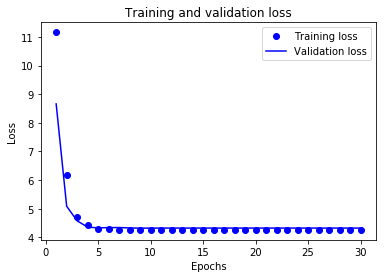

In [17]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

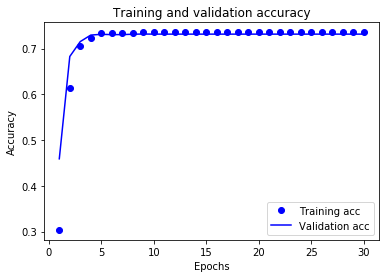

In [18]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()